In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def load_training():
    images = np.load(os.path.join('../Data_final_fullver', 'X_train.npy'))
    labels = np.load(os.path.join('../Data_final_fullver', 'train_labels1_num.npy'))
    filenames = np.load(os.path.join('../Data_final_fullver', 'CBIS_train_FNs.npy'))
    return images, labels, filenames


def load_testing():
    images = np.load(os.path.join('../Data_final_fullver', 'X_test.npy'))
    labels = np.load(os.path.join('../Data_final_fullver', 'test_labels1_num.npy'))
    filenames = np.load(os.path.join('../Data_final_fullver', 'CBIS_test_FNs.npy'))
    return images, labels, filenames

In [3]:
train_images, train_labels, Fn= load_training()
test_images, test_labels, Fn= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2925 	 Test size: 643
Image size: 256x256


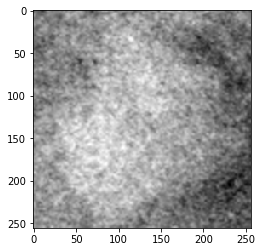

Label: 1
FN: Mass-Training_P_00106_LEFT_CC.png


In [4]:
idx = 10

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))
print("FN: " + str(Fn[idx]))

In [5]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [6]:
train_images.shape

(2925, 256, 256, 1)

In [7]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [8]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [10]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

In [11]:
def create_vgg19(verbose=False, fc_size=256, output = 4, dropout=None):

    vgg19_base = VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg19 = models.Sequential()
    vgg19.add(vgg19_base)

    vgg19.add(layers.Flatten())
    if dropout is not None:
        vgg19.add(layers.Dropout(dropout))
    vgg19.add(layers.Dense(1024, activation='relu'))
    vgg19.add(layers.Dense(fc_size, activation='relu'))
    vgg19.add(layers.Dense(output, activation='softmax'))

    vgg19_base.trainable = False
    
    if verbose:
        vgg19_base.summary()
        vgg19.summary()

    return vgg19

In [12]:
vgg = VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
for layer in vgg.layers:
    layer.trainable = False
vgg_maxpool = vgg.get_layer('block5_pool').output
FeatureFlatten = Flatten()(vgg_maxpool)
dense1 = Dense(1024, name = 'dense1', activation = 'relu')(FeatureFlatten)
dense2 = Dense(128, name = 'dense2', activation = 'relu')(dense1)
predictions = Dense(2, name = 'predictions', activation = 'softmax')(dense2)

new_vgg = Model(inputs = vgg.input, outputs = predictions)
new_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [13]:
vgg19_calc_or_mass_best_Adam = new_vgg

In [14]:
vgg19_calc_or_mass_best_RMSprop = new_vgg

In [22]:
vgg19_calc_or_mass_best_Adam = create_vgg19(dropout=0.5, fc_size=128, output = 2)

In [23]:
vgg19_calc_or_mass_best_Adam.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 48,401,602
Trainable params: 33,686,914
Non-trainable params: 14,714,688
___________________________________

### Adam

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_or_mass_best_Adam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_or_mass_best_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [16]:
# Train
history_vgg19_calc_or_mass_best_Adam = vgg19_calc_or_mass_best_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.5878 - recall: 0.5934
Epoch 00001: val_loss improved from inf to 0.73708, saving model to ../model/vgg19_calc_or_mass_best_Adam.h5
11/11 [==============================] - 24s 2s/step - loss: 1.5187 - recall: 0.5950 - val_loss: 0.7371 - val_recall: 0.7385
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5729 - recall: 0.7340
Epoch 00002: val_loss improved from 0.73708 to 0.53963, saving model to ../model/vgg19_calc_or_mass_best_Adam.h5
11/11 [==============================] - 21s 2s/step - loss: 0.5680 - recall: 0.7356 - val_loss: 0.5396 - val_recall: 0.7675
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5353 - recall: 0.7695
Epoch 00003: val_loss improved from 0.53963 to 0.41037, saving model to ../model/v

Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3443 - recall: 0.8328
Epoch 00028: val_loss did not improve from 0.36097
11/11 [==============================] - 22s 2s/step - loss: 0.3421 - recall: 0.8331 - val_loss: 0.3766 - val_recall: 0.8444
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3517 - recall: 0.8460
Epoch 00029: val_loss did not improve from 0.36097
11/11 [==============================] - 20s 2s/step - loss: 0.3552 - recall: 0.8412 - val_loss: 0.3781 - val_recall: 0.8479
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3122 - recall: 0.8617
Epoch 00030: val_loss improved from 0.36097 to 0.34085, saving model to ../model/vgg19_calc_or_mass_best_Adam.h5
11/11 [==============================] - 23s 2s/step - loss: 0.3117 - recall: 0.8651 - val_loss: 0.3408 - val_recall: 0.8462
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3224 - recall: 0.8645
Epoch 00031: val_loss did not impr

Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2998 - recall: 0.8664
Epoch 00058: val_loss did not improve from 0.30938
11/11 [==============================] - 21s 2s/step - loss: 0.3051 - recall: 0.8665 - val_loss: 0.3451 - val_recall: 0.8462
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2788 - recall: 0.8737
Epoch 00059: val_loss did not improve from 0.30938
11/11 [==============================] - 21s 2s/step - loss: 0.2779 - recall: 0.8746 - val_loss: 0.3568 - val_recall: 0.8342
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3105 - recall: 0.8703
Epoch 00060: val_loss did not improve from 0.30938
11/11 [==============================] - 22s 2s/step - loss: 0.3116 - recall: 0.8700 - val_loss: 0.3702 - val_recall: 0.8427
Epoch 61/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3161 - recall: 0.8633
Epoch 00061: val_loss did not improve from 0.30938
11/11 [==============================] - 21s 

In [17]:
models.save_model(vgg19_calc_or_mass_best_Adam, '../model/vgg19_calc_or_mass_end_Adam.h5')

In [18]:
tra_loss_fe = history_vgg19_calc_or_mass_best_Adam.history['loss']
tra_acc_fe = history_vgg19_calc_or_mass_best_Adam.history['recall']
val_loss_fe = history_vgg19_calc_or_mass_best_Adam.history['val_loss']
val_acc_fe = history_vgg19_calc_or_mass_best_Adam.history['val_recall']

In [19]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_or_mass = models.load_model('../model/vgg19_calc_or_mass_best_Adam.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_best_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

In [20]:
print("VGG19 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 calc or mass

Epoch [end]: 77
Epoch [opt]: 47
Valid recall [end]: 0.8752
Valid recall [opt]: 0.8769
Test recall [end]:  0.8414
Test recall [opt]:  0.8647
Valid loss [end]: 0.3269
Valid loss [opt]: 0.3094
Test loss [end]:  0.3951
Test loss [opt]:  0.3680


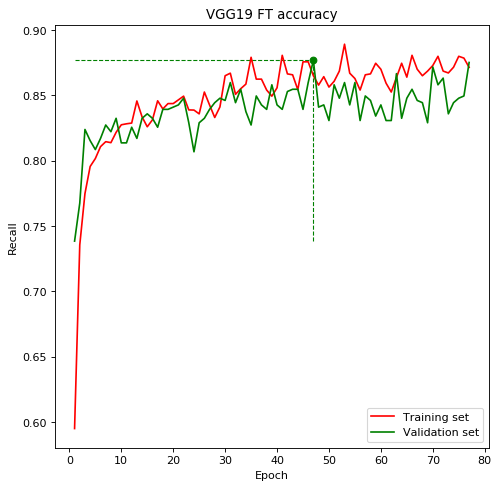

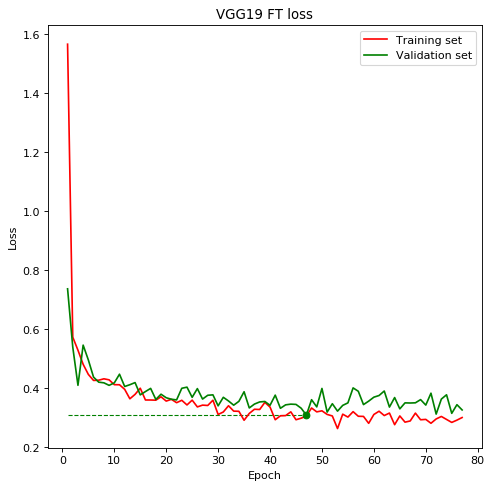

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### SGD

In [22]:
vgg19_calc_or_mass_best_SGD = create_vgg19(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_or_mass_best_SGD.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_or_mass_best_SGD.compile(optimizer=optimizers.SGD(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [23]:
# Train
history_vgg19_calc_or_mass_best_SGD = vgg19_calc_or_mass_best_SGD.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4367 - recall: 0.5234
Epoch 00001: val_loss improved from inf to 1.09435, saving model to ../model/vgg19_calc_or_mass_best_SGD.h5
11/11 [==============================] - 22s 2s/step - loss: 1.4128 - recall: 0.5249 - val_loss: 1.0944 - val_recall: 0.5778
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2600 - recall: 0.5586
Epoch 00002: val_loss improved from 1.09435 to 1.04074, saving model to ../model/vgg19_calc_or_mass_best_SGD.h5
11/11 [==============================] - 23s 2s/step - loss: 1.2387 - recall: 0.5639 - val_loss: 1.0407 - val_recall: 0.5692
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1931 - recall: 0.5699
Epoch 00003: val_loss improved from 1.04074 to 1.00652, saving model to ../model/vgg19_calc_or_mass_best_SGD.h5
11/11 [==============================] - 22s 2s/

Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8303 - recall: 0.6667
Epoch 00029: val_loss did not improve from 0.67306
11/11 [==============================] - 22s 2s/step - loss: 0.8230 - recall: 0.6687 - val_loss: 0.7444 - val_recall: 0.6940
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7812 - recall: 0.6719
Epoch 00030: val_loss did not improve from 0.67306
11/11 [==============================] - 22s 2s/step - loss: 0.7798 - recall: 0.6705 - val_loss: 0.7448 - val_recall: 0.6803
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8511 - recall: 0.6709
Epoch 00031: val_loss did not improve from 0.67306
11/11 [==============================] - 21s 2s/step - loss: 0.8387 - recall: 0.6733 - val_loss: 0.7047 - val_recall: 0.6906
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8018 - recall: 0.6719
Epoch 00032: val_loss did not improve from 0.67306
11/11 [==============================] - 22s 

Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6740 - recall: 0.6852
Epoch 00059: val_loss improved from 0.64112 to 0.58063, saving model to ../model/vgg19_calc_or_mass_best_SGD.h5
11/11 [==============================] - 22s 2s/step - loss: 0.6681 - recall: 0.6892 - val_loss: 0.5806 - val_recall: 0.7128
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7141 - recall: 0.6944
Epoch 00060: val_loss did not improve from 0.58063
11/11 [==============================] - 21s 2s/step - loss: 0.7176 - recall: 0.6930 - val_loss: 0.6249 - val_recall: 0.7162
Epoch 61/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7005 - recall: 0.7104
Epoch 00061: val_loss did not improve from 0.58063
11/11 [==============================] - 21s 2s/step - loss: 0.7102 - recall: 0.7082 - val_loss: 0.6949 - val_recall: 0.6718
Epoch 62/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6557 - recall: 0.7214
Epoch 00062: val_loss did not impro

Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6580 - recall: 0.7256
Epoch 00089: val_loss did not improve from 0.55663
11/11 [==============================] - 21s 2s/step - loss: 0.6745 - recall: 0.7211 - val_loss: 0.5873 - val_recall: 0.7504
Epoch 90/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6272 - recall: 0.7290
Epoch 00090: val_loss did not improve from 0.55663
11/11 [==============================] - 21s 2s/step - loss: 0.6354 - recall: 0.7325 - val_loss: 0.6135 - val_recall: 0.7282
Epoch 91/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6555 - recall: 0.7312
Epoch 00091: val_loss did not improve from 0.55663
11/11 [==============================] - 22s 2s/step - loss: 0.6533 - recall: 0.7337 - val_loss: 0.5926 - val_recall: 0.7145
Epoch 92/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6555 - recall: 0.7205
Epoch 00092: val_loss did not improve from 0.55663
11/11 [==============================] - 20s 

Epoch 119/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6388 - recall: 0.7138
Epoch 00119: val_loss did not improve from 0.51595
11/11 [==============================] - 22s 2s/step - loss: 0.6556 - recall: 0.7082 - val_loss: 0.5729 - val_recall: 0.7419
Epoch 120/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6030 - recall: 0.7430
Epoch 00120: val_loss did not improve from 0.51595
11/11 [==============================] - 22s 2s/step - loss: 0.5963 - recall: 0.7422 - val_loss: 0.5983 - val_recall: 0.7385
Epoch 121/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6194 - recall: 0.7414
Epoch 00121: val_loss did not improve from 0.51595
11/11 [==============================] - 21s 2s/step - loss: 0.6078 - recall: 0.7436 - val_loss: 0.5353 - val_recall: 0.7573
Epoch 122/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6870 - recall: 0.7188
Epoch 00122: val_loss did not improve from 0.51595
11/11 [==============================] - 

10/11 [==========================>...] - ETA: 1s - loss: 0.6089 - recall: 0.7430
Epoch 00149: val_loss did not improve from 0.50105
11/11 [==============================] - 22s 2s/step - loss: 0.5978 - recall: 0.7457 - val_loss: 0.5076 - val_recall: 0.7675
Epoch 150/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6206 - recall: 0.7266
Epoch 00150: val_loss did not improve from 0.50105
11/11 [==============================] - 21s 2s/step - loss: 0.6109 - recall: 0.7308 - val_loss: 0.5821 - val_recall: 0.7333
Epoch 151/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5708 - recall: 0.7365
Epoch 00151: val_loss did not improve from 0.50105
11/11 [==============================] - 21s 2s/step - loss: 0.5621 - recall: 0.7401 - val_loss: 0.5243 - val_recall: 0.7470
Epoch 152/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6122 - recall: 0.7517
Epoch 00152: val_loss did not improve from 0.50105
11/11 [==============================] - 21s 2s/step - 

In [24]:
models.save_model(vgg19_calc_or_mass_best_SGD, '../model/vgg19_calc_or_mass_end_SGD.h5')

In [25]:
tra_loss_fe = history_vgg19_calc_or_mass_best_SGD.history['loss']
tra_acc_fe = history_vgg19_calc_or_mass_best_SGD.history['recall']
val_loss_fe = history_vgg19_calc_or_mass_best_SGD.history['val_loss']
val_acc_fe = history_vgg19_calc_or_mass_best_SGD.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_or_mass = models.load_model('../model/vgg19_calc_or_mass_best_SGD.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_best_SGD.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG19 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 calc or mass

Epoch [end]: 163
Epoch [opt]: 133
Valid recall [end]: 0.7385
Valid recall [opt]: 0.7658
Test recall [end]:  0.7745
Test recall [opt]:  0.7652
Valid loss [end]: 0.5628
Valid loss [opt]: 0.5011
Test loss [end]:  0.5451
Test loss [opt]:  0.5571


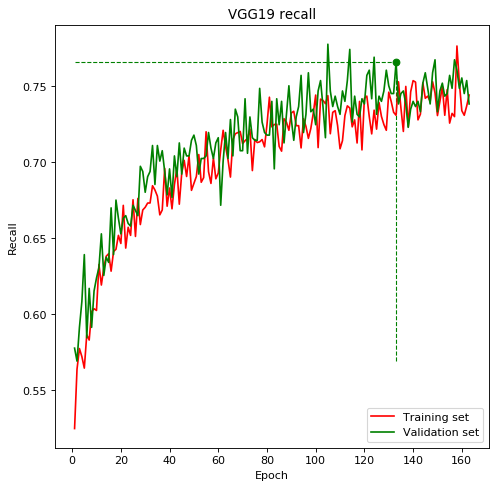

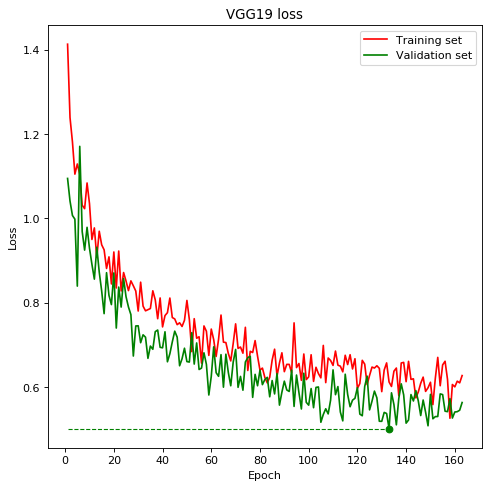

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### RMSprop

In [27]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_or_mass_best_RMSprop.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_or_mass_best_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [28]:
# Train
history_vgg19_calc_or_mass_best_RMSprop = vgg19_calc_or_mass_best_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5161 - recall: 0.8443
Epoch 00001: val_loss improved from inf to 0.38225, saving model to ../model/vgg19_calc_or_mass_best_RMSprop.h5
11/11 [==============================] - 22s 2s/step - loss: 0.4941 - recall: 0.8465 - val_loss: 0.3822 - val_recall: 0.8393
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3693 - recall: 0.8443
Epoch 00002: val_loss improved from 0.38225 to 0.34998, saving model to ../model/vgg19_calc_or_mass_best_RMSprop.h5
11/11 [==============================] - 22s 2s/step - loss: 0.3681 - recall: 0.8473 - val_loss: 0.3500 - val_recall: 0.8376
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3519 - recall: 0.8485
Epoch 00003: val_loss did not improve from 0.34998
11/11 [==============================] - 21s 2s/step - loss: 0.3469 - recall: 0.8526 - val_loss: 0.39

In [29]:
models.save_model(vgg19_calc_or_mass_best_RMSprop, '../model/vgg19_calc_or_mass_end_RMSprop.h5')

In [30]:
tra_loss_fe = history_vgg19_calc_or_mass_best_RMSprop.history['loss']
tra_acc_fe = history_vgg19_calc_or_mass_best_RMSprop.history['recall']
val_loss_fe = history_vgg19_calc_or_mass_best_RMSprop.history['val_loss']
val_acc_fe = history_vgg19_calc_or_mass_best_RMSprop.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_or_mass = models.load_model('../model/vgg19_calc_or_mass_best_RMSprop.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_best_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG19 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 calc or mass

Epoch [end]: 57
Epoch [opt]: 27
Valid recall [end]: 0.8496
Valid recall [opt]: 0.8581
Test recall [end]:  0.8243
Test recall [opt]:  0.8476
Valid loss [end]: 0.3548
Valid loss [opt]: 0.3132
Test loss [end]:  0.5056
Test loss [opt]:  0.4317


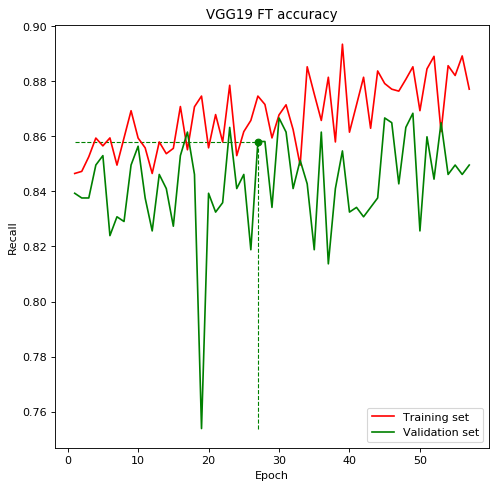

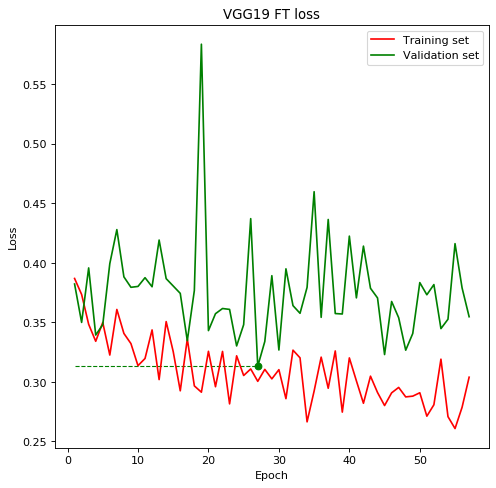

In [31]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adadelta

In [32]:
vgg19_calc_or_mass_best_Adadelta = create_vgg19(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_or_mass_best_Adadelta.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_or_mass_best_Adadelta.compile(optimizer=optimizers.Adadelta(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [33]:
# Train
history_vgg19_calc_or_mass_best_Adadelta = vgg19_calc_or_mass_best_Adadelta.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 2.2651 - recall: 0.4984
Epoch 00001: val_loss improved from inf to 1.75517, saving model to ../model/vgg19_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 23s 2s/step - loss: 2.2247 - recall: 0.5014 - val_loss: 1.7552 - val_recall: 0.5316
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 2.2607 - recall: 0.5078
Epoch 00002: val_loss improved from 1.75517 to 1.72710, saving model to ../model/vgg19_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 23s 2s/step - loss: 2.2377 - recall: 0.5099 - val_loss: 1.7271 - val_recall: 0.5333
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 2.2147 - recall: 0.5164
Epoch 00003: val_loss improved from 1.72710 to 1.67775, saving model to ../model/vgg19_calc_or_mass_best_Adadelta.h5
11/11 [==========================

Epoch 27/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3526 - recall: 0.5172
Epoch 00027: val_loss did not improve from 0.96563
11/11 [==============================] - 21s 2s/step - loss: 1.3655 - recall: 0.5192 - val_loss: 1.0336 - val_recall: 0.5128
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3463 - recall: 0.5000
Epoch 00028: val_loss did not improve from 0.96563
11/11 [==============================] - 20s 2s/step - loss: 1.3407 - recall: 0.5023 - val_loss: 0.9671 - val_recall: 0.4906
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2447 - recall: 0.5219
Epoch 00029: val_loss improved from 0.96563 to 0.94988, saving model to ../model/vgg19_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 23s 2s/step - loss: 1.2379 - recall: 0.5277 - val_loss: 0.9499 - val_recall: 0.5402
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2935 - recall: 0.5109
Epoch 00030: val_loss improved

Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1681 - recall: 0.5152
Epoch 00057: val_loss did not improve from 0.79815
11/11 [==============================] - 21s 2s/step - loss: 1.1499 - recall: 0.5258 - val_loss: 1.0500 - val_recall: 0.5573
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1980 - recall: 0.5429
Epoch 00058: val_loss did not improve from 0.79815
11/11 [==============================] - 22s 2s/step - loss: 1.2233 - recall: 0.5395 - val_loss: 0.9893 - val_recall: 0.5436
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2066 - recall: 0.5303
Epoch 00059: val_loss did not improve from 0.79815
11/11 [==============================] - 21s 2s/step - loss: 1.2177 - recall: 0.5213 - val_loss: 0.9330 - val_recall: 0.5538
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1886 - recall: 0.5297
Epoch 00060: val_loss did not improve from 0.79815
11/11 [==============================] - 22s 

In [34]:
models.save_model(vgg19_calc_or_mass_best_Adadelta, '../model/vgg19_calc_or_mass_end_Adadelta.h5')

In [35]:
tra_loss_fe = history_vgg19_calc_or_mass_best_Adadelta.history['loss']
tra_acc_fe = history_vgg19_calc_or_mass_best_Adadelta.history['recall']
val_loss_fe = history_vgg19_calc_or_mass_best_Adadelta.history['val_loss']
val_acc_fe = history_vgg19_calc_or_mass_best_Adadelta.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_or_mass = models.load_model('../model/vgg19_calc_or_mass_best_Adadelta.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_best_Adadelta.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG19 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 calc or mass

Epoch [end]: 63
Epoch [opt]: 33
Valid recall [end]: 0.5795
Valid recall [opt]: 0.5761
Test recall [end]:  0.5816
Test recall [opt]:  0.5443
Valid loss [end]: 0.9422
Valid loss [opt]: 0.7982
Test loss [end]:  1.1000
Test loss [opt]:  1.0339


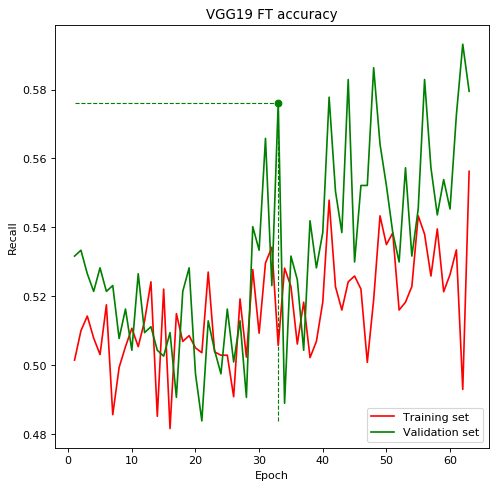

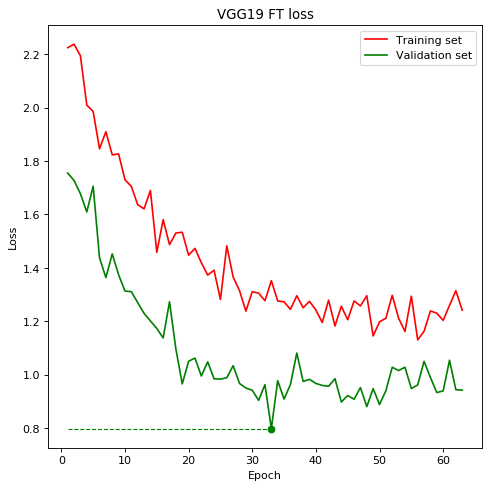

In [36]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adagrad

In [13]:
vgg19_calc_or_mass_best_Adagrad = create_vgg19(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_or_mass_best_Adagrad.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_or_mass_best_Adagrad.compile(optimizer=optimizers.Adagrad(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [14]:
# Train
history_vgg19_calc_or_mass_best_Adagrad = vgg19_calc_or_mass_best_Adagrad.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3187 - recall: 0.5345
Epoch 00001: val_loss improved from inf to 0.88877, saving model to ../model/vgg19_calc_or_mass_best_Adagrad.h5
11/11 [==============================] - 24s 2s/step - loss: 1.3171 - recall: 0.5327 - val_loss: 0.8888 - val_recall: 0.5658
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0585 - recall: 0.5688
Epoch 00002: val_loss improved from 0.88877 to 0.77401, saving model to ../model/vgg19_calc_or_mass_best_Adagrad.h5
11/11 [==============================] - 22s 2s/step - loss: 1.0595 - recall: 0.5661 - val_loss: 0.7740 - val_recall: 0.6701
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0040 - recall: 0.5960
Epoch 00003: val_loss improved from 0.77401 to 0.72178, saving model to ../m

10/11 [==========================>...] - ETA: 1s - loss: 0.7175 - recall: 0.6970
Epoch 00027: val_loss improved from 0.53142 to 0.50937, saving model to ../model/vgg19_calc_or_mass_best_Adagrad.h5
11/11 [==============================] - 21s 2s/step - loss: 0.7135 - recall: 0.6976 - val_loss: 0.5094 - val_recall: 0.7641
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6868 - recall: 0.7205
Epoch 00028: val_loss improved from 0.50937 to 0.50140, saving model to ../model/vgg19_calc_or_mass_best_Adagrad.h5
11/11 [==============================] - 22s 2s/step - loss: 0.6892 - recall: 0.7242 - val_loss: 0.5014 - val_recall: 0.7692
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7041 - recall: 0.7113
Epoch 00029: val_loss did not improve from 0.50140
11/11 [==============================] - 21s 2s/step - loss: 0.7055 - recall: 0.7105 - val_loss: 0.5359 - val_recall: 0.7761
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6

Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6224 - recall: 0.7367
Epoch 00057: val_loss improved from 0.48076 to 0.45635, saving model to ../model/vgg19_calc_or_mass_best_Adagrad.h5
11/11 [==============================] - 22s 2s/step - loss: 0.6153 - recall: 0.7393 - val_loss: 0.4564 - val_recall: 0.7966
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5778 - recall: 0.7652
Epoch 00058: val_loss did not improve from 0.45635
11/11 [==============================] - 21s 2s/step - loss: 0.5669 - recall: 0.7644 - val_loss: 0.5176 - val_recall: 0.7761
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6233 - recall: 0.7359
Epoch 00059: val_loss did not improve from 0.45635
11/11 [==============================] - 22s 2s/step - loss: 0.6317 - recall: 0.7322 - val_loss: 0.4967 - val_recall: 0.7744
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6578 - recall: 0.7374
Epoch 00060: val_loss did not i

Epoch 87/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6148 - recall: 0.7594
Epoch 00087: val_loss did not improve from 0.45131
11/11 [==============================] - 22s 2s/step - loss: 0.6313 - recall: 0.7500 - val_loss: 0.5087 - val_recall: 0.8017
Epoch 88/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6240 - recall: 0.7399
Epoch 00088: val_loss did not improve from 0.45131
11/11 [==============================] - 20s 2s/step - loss: 0.6163 - recall: 0.7439 - val_loss: 0.4948 - val_recall: 0.7829
Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5791 - recall: 0.7570
Epoch 00089: val_loss did not improve from 0.45131
11/11 [==============================] - 22s 2s/step - loss: 0.5854 - recall: 0.7514 - val_loss: 0.4749 - val_recall: 0.7897
Epoch 90/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5983 - recall: 0.7563
Epoch 00090: val_loss improved from 0.45131 to 0.45106, saving model to ../model/vgg19_calc_or_m

Epoch 117/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5846 - recall: 0.7508
Epoch 00117: val_loss did not improve from 0.42954
11/11 [==============================] - 21s 2s/step - loss: 0.5814 - recall: 0.7523 - val_loss: 0.4636 - val_recall: 0.7761
Epoch 118/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5468 - recall: 0.7652
Epoch 00118: val_loss did not improve from 0.42954
11/11 [==============================] - 21s 2s/step - loss: 0.5488 - recall: 0.7652 - val_loss: 0.4830 - val_recall: 0.7897
Epoch 119/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5891 - recall: 0.7453
Epoch 00119: val_loss did not improve from 0.42954
11/11 [==============================] - 22s 2s/step - loss: 0.5809 - recall: 0.7514 - val_loss: 0.4568 - val_recall: 0.7812
Epoch 120/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5132 - recall: 0.7702
Epoch 00120: val_loss did not improve from 0.42954
11/11 [==============================] - 

In [15]:
models.save_model(vgg19_calc_or_mass_best_Adagrad, '../model/vgg19_calc_or_mass_end_Adagrad.h5')

In [16]:
tra_loss_fe = history_vgg19_calc_or_mass_best_Adagrad.history['loss']
tra_acc_fe = history_vgg19_calc_or_mass_best_Adagrad.history['recall']
val_loss_fe = history_vgg19_calc_or_mass_best_Adagrad.history['val_loss']
val_acc_fe = history_vgg19_calc_or_mass_best_Adagrad.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_or_mass = models.load_model('../model/vgg19_calc_or_mass_best_Adagrad.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_best_Adagrad.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG19 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 calc or mass

Epoch [end]: 125
Epoch [opt]: 95
Valid recall [end]: 0.7744
Valid recall [opt]: 0.8154
Test recall [end]:  0.7869
Test recall [opt]:  0.7807
Valid loss [end]: 0.4954
Valid loss [opt]: 0.4295
Test loss [end]:  0.4806
Test loss [opt]:  0.4998


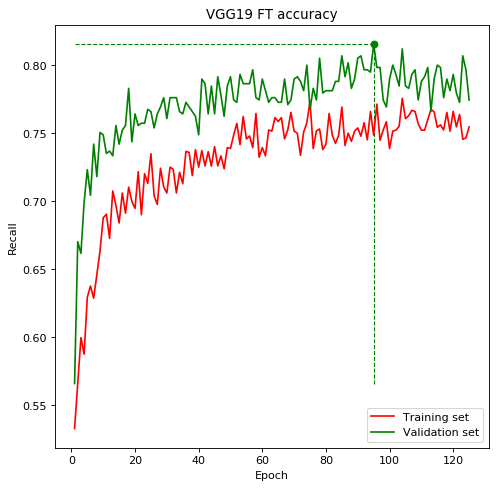

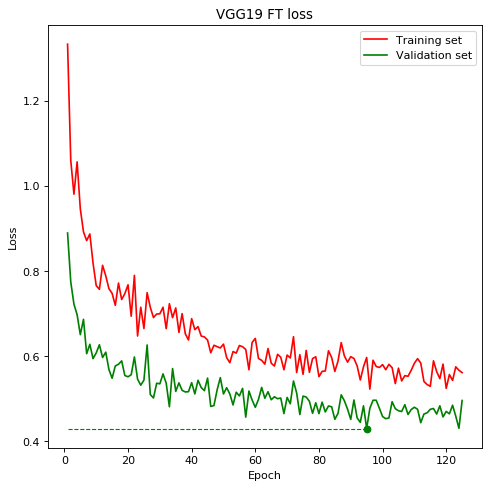

In [17]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adamax

In [18]:
vgg19_calc_or_mass_best_Adamax = create_vgg19(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_or_mass_best_Adamax.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_or_mass_best_Adamax.compile(optimizer=optimizers.Adamax(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [19]:
# Train
history_vgg19_calc_or_mass_best_Adamax = vgg19_calc_or_mass_best_Adamax.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0951 - recall: 0.6448
Epoch 00001: val_loss improved from inf to 0.67423, saving model to ../model/vgg19_calc_or_mass_best_Adamax.h5
11/11 [==============================] - 21s 2s/step - loss: 1.0729 - recall: 0.6429 - val_loss: 0.6742 - val_recall: 0.6684
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7084 - recall: 0.6827
Epoch 00002: val_loss improved from 0.67423 to 0.57731, saving model to ../model/vgg19_calc_or_mass_best_Adamax.h5
11/11 [==============================] - 21s 2s/step - loss: 0.7233 - recall: 0.6763 - val_loss: 0.5773 - val_recall: 0.7521
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6465 - recall: 0.7164
Epoch 00003: val_loss improved from 0.57731 to 0.55536, saving model to ../model/vgg19_calc_or_mass_best_Adamax.h5
11/11 [==============================] 

Epoch 56/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4036 - recall: 0.8199
Epoch 00056: val_loss improved from 0.33383 to 0.32751, saving model to ../model/vgg19_calc_or_mass_best_Adamax.h5
11/11 [==============================] - 22s 2s/step - loss: 0.4091 - recall: 0.8176 - val_loss: 0.3275 - val_recall: 0.8325
Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3832 - recall: 0.8273
Epoch 00057: val_loss did not improve from 0.32751
11/11 [==============================] - 22s 2s/step - loss: 0.3785 - recall: 0.8324 - val_loss: 0.3408 - val_recall: 0.8479
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4210 - recall: 0.8131
Epoch 00058: val_loss did not improve from 0.32751
11/11 [==============================] - 20s 2s/step - loss: 0.4261 - recall: 0.8100 - val_loss: 0.3747 - val_recall: 0.8325
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4100 - recall: 0.8211
Epoch 00059: val_loss did not im

Epoch 86/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3969 - recall: 0.8148
Epoch 00086: val_loss did not improve from 0.31631
11/11 [==============================] - 21s 2s/step - loss: 0.3918 - recall: 0.8168 - val_loss: 0.3171 - val_recall: 0.8581
Epoch 87/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3777 - recall: 0.8266
Epoch 00087: val_loss did not improve from 0.31631
11/11 [==============================] - 21s 2s/step - loss: 0.3801 - recall: 0.8260 - val_loss: 0.3697 - val_recall: 0.8393
Epoch 88/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3865 - recall: 0.8215
Epoch 00088: val_loss did not improve from 0.31631
11/11 [==============================] - 21s 2s/step - loss: 0.3936 - recall: 0.8199 - val_loss: 0.3292 - val_recall: 0.8547
Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3921 - recall: 0.8203
Epoch 00089: val_loss did not improve from 0.31631
11/11 [==============================] - 22s 

10/11 [==========================>...] - ETA: 1s - loss: 0.3563 - recall: 0.8476
Epoch 00116: val_loss did not improve from 0.31336
11/11 [==============================] - 20s 2s/step - loss: 0.3629 - recall: 0.8457 - val_loss: 0.3612 - val_recall: 0.8376
Epoch 117/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4034 - recall: 0.8157
Epoch 00117: val_loss did not improve from 0.31336
11/11 [==============================] - 21s 2s/step - loss: 0.4048 - recall: 0.8153 - val_loss: 0.3404 - val_recall: 0.8479
Epoch 118/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3890 - recall: 0.8342
Epoch 00118: val_loss did not improve from 0.31336
11/11 [==============================] - 21s 2s/step - loss: 0.3881 - recall: 0.8351 - val_loss: 0.3139 - val_recall: 0.8581
Epoch 119/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3554 - recall: 0.8409
Epoch 00119: val_loss did not improve from 0.31336
11/11 [==============================] - 21s 2s/step - 

In [20]:
models.save_model(vgg19_calc_or_mass_best_Adamax, '../model/vgg19_calc_or_mass_end_Adamax.h5')

In [21]:
tra_loss_fe = history_vgg19_calc_or_mass_best_Adamax.history['loss']
tra_acc_fe = history_vgg19_calc_or_mass_best_Adamax.history['recall']
val_loss_fe = history_vgg19_calc_or_mass_best_Adamax.history['val_loss']
val_acc_fe = history_vgg19_calc_or_mass_best_Adamax.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_or_mass = models.load_model('../model/vgg19_calc_or_mass_best_Adamax.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_best_Adamax.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG19 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 calc or mass

Epoch [end]: 138
Epoch [opt]: 108
Valid recall [end]: 0.8513
Valid recall [opt]: 0.8684
Test recall [end]:  0.8554
Test recall [opt]:  0.8694
Valid loss [end]: 0.3482
Valid loss [opt]: 0.3134
Test loss [end]:  0.3415
Test loss [opt]:  0.3129


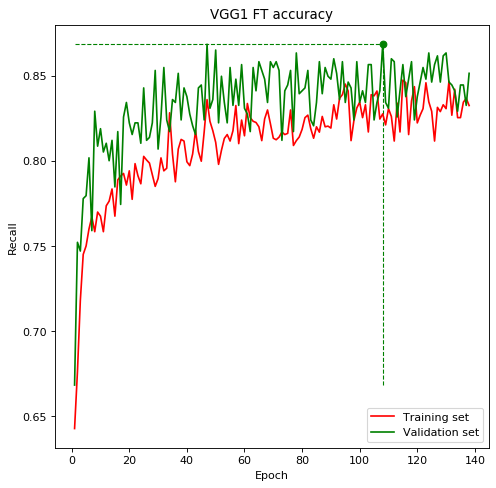

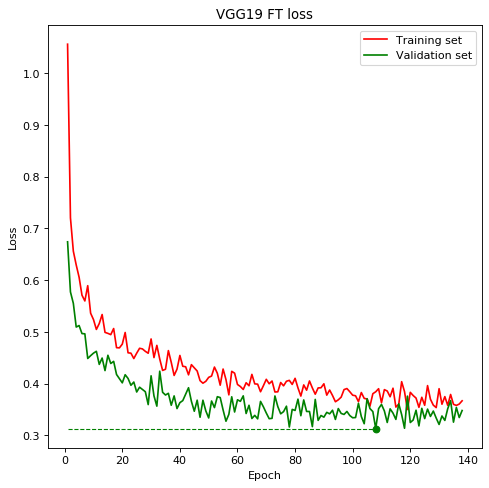

In [22]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG1 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Nadam

In [14]:
vgg19_calc_or_mass_best_Nadam = create_vgg19(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_or_mass_best_Nadam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_or_mass_best_Nadam.compile(optimizer=optimizers.Nadam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [15]:
# Train
history_vgg19_calc_or_mass_best_Nadam = vgg19_calc_or_mass_best_Nadam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4970 - recall: 0.5631
Epoch 00001: val_loss improved from inf to 0.63378, saving model to ../model/vgg19_calc_or_mass_best_Nadam.h5
11/11 [==============================] - 24s 2s/step - loss: 1.4290 - recall: 0.5767 - val_loss: 0.6338 - val_recall: 0.7009
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7286 - recall: 0.6835
Epoch 00002: val_loss improved from 0.63378 to 0.53769, saving model to ../model/vgg19_calc_or_mass_best_Nadam.h5
11/11 [==============================] - 21s 2s/step - loss: 0.7186 - recall: 0.6884 - val_loss: 0.5377 - val_recall: 0.7932
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6302 - recall: 0.7197
Epoch 00003: val_loss improved from 0.53769 to 0.49715, saving model to ../model

Epoch 27/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4095 - recall: 0.8156
Epoch 00027: val_loss did not improve from 0.32578
11/11 [==============================] - 22s 2s/step - loss: 0.4011 - recall: 0.8196 - val_loss: 0.3829 - val_recall: 0.8222
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3770 - recall: 0.8258
Epoch 00028: val_loss did not improve from 0.32578
11/11 [==============================] - 20s 2s/step - loss: 0.3715 - recall: 0.8260 - val_loss: 0.3576 - val_recall: 0.8085
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4251 - recall: 0.8047
Epoch 00029: val_loss did not improve from 0.32578
11/11 [==============================] - 21s 2s/step - loss: 0.4251 - recall: 0.8017 - val_loss: 0.3797 - val_recall: 0.8256
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3947 - recall: 0.8148
Epoch 00030: val_loss did not improve from 0.32578
11/11 [==============================] - 22s 

Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3764 - recall: 0.8180
Epoch 00057: val_loss did not improve from 0.30613
11/11 [==============================] - 22s 2s/step - loss: 0.3677 - recall: 0.8239 - val_loss: 0.3185 - val_recall: 0.8650
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3610 - recall: 0.8484
Epoch 00058: val_loss did not improve from 0.30613
11/11 [==============================] - 21s 2s/step - loss: 0.3668 - recall: 0.8459 - val_loss: 0.3107 - val_recall: 0.8530
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3516 - recall: 0.8384
Epoch 00059: val_loss did not improve from 0.30613
11/11 [==============================] - 20s 2s/step - loss: 0.3503 - recall: 0.8381 - val_loss: 0.3360 - val_recall: 0.8530
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3358 - recall: 0.8493
Epoch 00060: val_loss did not improve from 0.30613
11/11 [==============================] - 21s 

In [16]:
models.save_model(vgg19_calc_or_mass_best_Nadam, '../model/vgg19_calc_or_mass_end_Nadam.h5')

In [17]:
tra_loss_fe = history_vgg19_calc_or_mass_best_Nadam.history['loss']
tra_acc_fe = history_vgg19_calc_or_mass_best_Nadam.history['recall']
val_loss_fe = history_vgg19_calc_or_mass_best_Nadam.history['val_loss']
val_acc_fe = history_vgg19_calc_or_mass_best_Nadam.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_or_mass = models.load_model('../model/vgg19_calc_or_mass_best_Nadam.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_best_Nadam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG19 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 calc or mass

Epoch [end]: 100
Epoch [opt]: 70
Valid recall [end]: 0.8462
Valid recall [opt]: 0.8769
Test recall [end]:  0.8523
Test recall [opt]:  0.8631
Valid loss [end]: 0.3305
Valid loss [opt]: 0.2973
Test loss [end]:  0.3162
Test loss [opt]:  0.3175


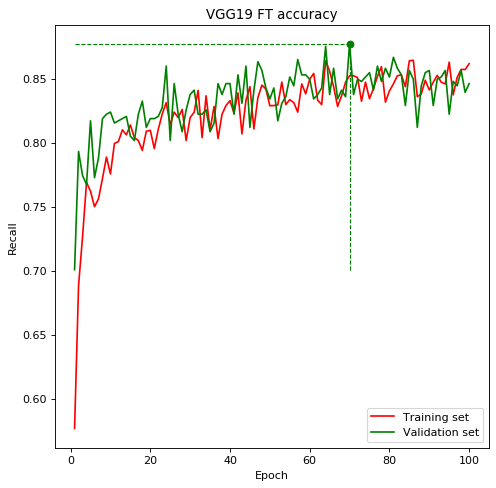

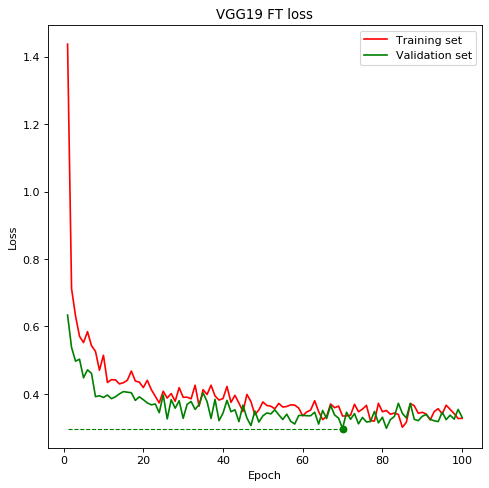

In [18]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#### fine tuning

In [19]:
vgg19_calc_or_mass_fine_Adam = models.load_model('../model/vgg19_calc_or_mass_best_Adam.h5')

for layer in vgg19_calc_or_mass_fine_Adam.layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_calc_or_mass_fine_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg19_calc_or_mass_fine_Adam.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [20]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg19_calc_or_mass_fine_Adam_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [21]:
history_fit = vgg19_calc_or_mass_fine_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3017 - recall: 0.8695
Epoch 00001: val_loss improved from inf to 0.32266, saving model to ../model/vgg19_calc_or_mass_fine_Adam_best.h5
11/11 [==============================] - 21s 2s/step - loss: 0.2907 - recall: 0.8754 - val_loss: 0.3227 - val_recall: 0.8701
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2928 - recall: 0.8670
Epoch 00002: val_loss improved from 0.32266 to 0.30253, saving model to ../model/vgg19_calc_or_mass_fine_Adam_best.h5
11/11 [==============================] - 21s 2s/step - loss: 0.2881 - recall: 0.8678 - val_loss: 0.3025 - val_recall: 0.8479
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3040 - recall: 0.8704
Epoch 00003: val_loss did not improve from 0.30253
11/11 [==============================] - 21s 2s/step - loss: 0.2985 - recall: 0.8739 - val_loss: 

Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2271 - recall: 0.9066
Epoch 00029: val_loss did not improve from 0.24783
11/11 [==============================] - 20s 2s/step - loss: 0.2202 - recall: 0.9111 - val_loss: 0.2582 - val_recall: 0.8906
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2193 - recall: 0.9175
Epoch 00030: val_loss did not improve from 0.24783
11/11 [==============================] - 21s 2s/step - loss: 0.2179 - recall: 0.9172 - val_loss: 0.2989 - val_recall: 0.8718
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2199 - recall: 0.9109
Epoch 00031: val_loss did not improve from 0.24783
11/11 [==============================] - 22s 2s/step - loss: 0.2342 - recall: 0.9048 - val_loss: 0.2547 - val_recall: 0.8974
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2076 - recall: 0.9117
Epoch 00032: val_loss did not improve from 0.24783
11/11 [==============================] - 20s 

Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2109 - recall: 0.9125
Epoch 00089: val_loss did not improve from 0.20744
11/11 [==============================] - 21s 2s/step - loss: 0.2096 - recall: 0.9119 - val_loss: 0.2509 - val_recall: 0.8872
Epoch 90/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1905 - recall: 0.9184
Epoch 00090: val_loss did not improve from 0.20744
11/11 [==============================] - 21s 2s/step - loss: 0.1929 - recall: 0.9157 - val_loss: 0.3041 - val_recall: 0.8547
Epoch 91/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1795 - recall: 0.9234
Epoch 00091: val_loss did not improve from 0.20744
11/11 [==============================] - 21s 2s/step - loss: 0.1873 - recall: 0.9195 - val_loss: 0.2538 - val_recall: 0.8923
Epoch 92/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1770 - recall: 0.9175
Epoch 00092: val_loss did not improve from 0.20744
11/11 [==============================] - 21s 

In [22]:
models.save_model(vgg19_calc_or_mass_fine_Adam, '../model/vgg19_calc_or_mass_fine_Adam_end.h5')

In [25]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_calc_or_mass_fine_Adam = models.load_model('../model/vgg19_calc_or_mass_fine_Adam_best.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_fine_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass_fine_Adam.evaluate(test_images, test_labels, verbose=False)

print("VGG1recall Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG1recall Fine Tuning

Epoch [end]: 105
Epoch [opt]: 75
Valid recall [end]: 0.8991
Valid recall [opt]: 0.9077
Test recall [end]:  0.9020
Test recall [opt]:  0.8942
Valid loss [end]: 0.2442
Valid loss [opt]: 0.2074
Test loss [end]:  0.2484
Test loss [opt]:  0.2736


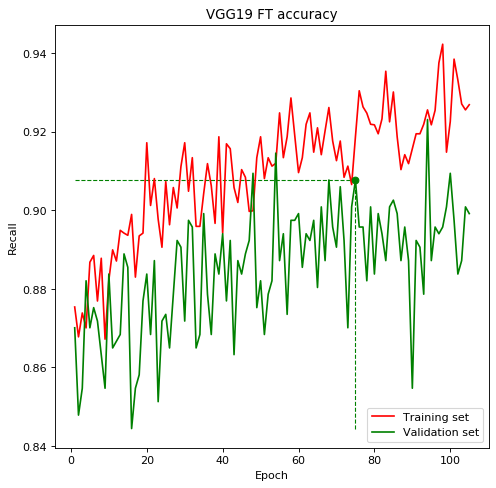

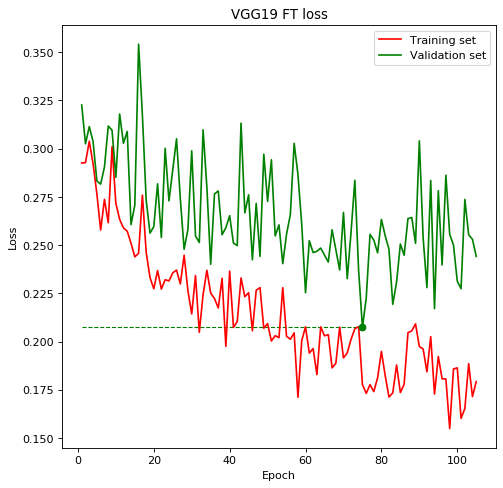

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [27]:
vgg19_calc_or_mass_fine_Adam2 = models.load_model('../model/vgg19_calc_or_mass_fine_Adam_best.h5')

for layer in vgg19_calc_or_mass_fine_Adam2.layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_calc_or_mass_fine_Adam2.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg19_calc_or_mass_fine_Adam.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [28]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg19_calc_or_mass_fine_Adam_best2.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [29]:
history_fit = vgg19_calc_or_mass_fine_Adam2.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2397 - recall: 0.8930
Epoch 00001: val_loss improved from inf to 0.31175, saving model to ../model/vgg19_calc_or_mass_fine_Adam_best2.h5
11/11 [==============================] - 21s 2s/step - loss: 0.2305 - recall: 0.8936 - val_loss: 0.3118 - val_recall: 0.8786
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2113 - recall: 0.9109
Epoch 00002: val_loss improved from 0.31175 to 0.25478, saving model to ../model/vgg19_calc_or_mass_fine_Adam_best2.h5
11/11 [==============================] - 21s 2s/step - loss: 0.2024 - recall: 0.9119 - val_loss: 0.2548 - val_recall: 0.8838
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2509 - recall: 0.8965
Epoch 00003: val_loss did not improve from 0.25478
11/11 [==============================] - 21s 2s/step - loss: 0.2479 - recall: 0.8974 - val_loss

10/11 [==========================>...] - ETA: 1s - loss: 0.1560 - recall: 0.9375
Epoch 00059: val_loss did not improve from 0.20283
11/11 [==============================] - 21s 2s/step - loss: 0.1468 - recall: 0.9384 - val_loss: 0.2339 - val_recall: 0.9094
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1786 - recall: 0.9293
Epoch 00060: val_loss did not improve from 0.20283
11/11 [==============================] - 20s 2s/step - loss: 0.1792 - recall: 0.9301 - val_loss: 0.3492 - val_recall: 0.8821
Epoch 61/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1815 - recall: 0.9219
Epoch 00061: val_loss did not improve from 0.20283
11/11 [==============================] - 22s 2s/step - loss: 0.1872 - recall: 0.9190 - val_loss: 0.2755 - val_recall: 0.8855
Epoch 62/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1730 - recall: 0.9293
Epoch 00062: val_loss did not improve from 0.20283
11/11 [==============================] - 20s 2s/step - los

In [30]:
models.save_model(vgg19_calc_or_mass_fine_Adam2, '../model/vgg19_calc_or_mass_fine_Adam_end2.h5')

In [31]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_calc_or_mass_fine_Adam2 = models.load_model('../model/vgg19_calc_or_mass_fine_Adam_best2.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_fine_Adam2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass_fine_Adam2.evaluate(test_images, test_labels, verbose=False)

print("VGG19 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 Fine Tuning

Epoch [end]: 85
Epoch [opt]: 55
Valid recall [end]: 0.8974
Valid recall [opt]: 0.9197
Test recall [end]:  0.9082
Test recall [opt]:  0.9269
Valid loss [end]: 0.2653
Valid loss [opt]: 0.2028
Test loss [end]:  0.2369
Test loss [opt]:  0.2120


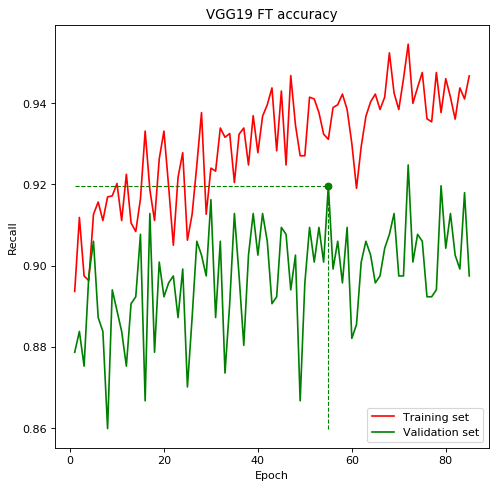

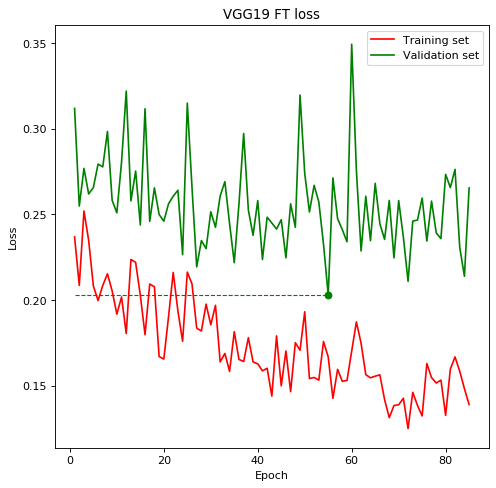

In [32]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [13]:
vgg19_calc_or_mass_fine_Adam3 = models.load_model('../model/vgg19_calc_or_mass_fine_Adam_best2.h5')

for layer in vgg19_calc_or_mass_fine_Adam3.layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_calc_or_mass_fine_Adam3.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg19_calc_or_mass_fine_Adam3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [14]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg19_calc_or_mass_fine_Adam_best3.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [15]:
history_fit = vgg19_calc_or_mass_fine_Adam3.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2837 - recall: 0.8872
Epoch 00001: val_loss improved from inf to 0.30875, saving model to ../model/vgg19_calc_or_mass_fine_Adam_best3.h5
11/11 [==============================] - 24s 2s/step - loss: 0.2798 - recall: 0.8875 - val_loss: 0.3088 - val_recall: 0.8838
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2020 - recall: 0.9266
Epoch 00002: val_loss improved from 0.30875 to 0.26468, saving model to ../model/vgg19_calc_or_mass_fine_Adam_best3.h5
11/11 [==============================] - 22s 2s/step - loss: 0.2046 - recall: 0.9247 - val_loss: 0.2647 - val_recall: 0.9060
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1963 - recall: 0.9158
Epoch 00003: val_loss improved from 0.26468 to 0.22849, saving model t

Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1568 - recall: 0.9453
Epoch 00029: val_loss did not improve from 0.20820
11/11 [==============================] - 22s 2s/step - loss: 0.1507 - recall: 0.9474 - val_loss: 0.2646 - val_recall: 0.9077
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1642 - recall: 0.9281
Epoch 00030: val_loss did not improve from 0.20820
11/11 [==============================] - 22s 2s/step - loss: 0.1629 - recall: 0.9283 - val_loss: 0.2154 - val_recall: 0.9128
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1347 - recall: 0.9391
Epoch 00031: val_loss did not improve from 0.20820
11/11 [==============================] - 21s 2s/step - loss: 0.1312 - recall: 0.9418 - val_loss: 0.2505 - val_recall: 0.9197
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1437 - recall: 0.9461
Epoch 00032: val_loss did not improve from 0.20820
11/11 [==============================] - 20s 

10/11 [==========================>...] - ETA: 1s - loss: 0.1453 - recall: 0.9406
Epoch 00059: val_loss did not improve from 0.20788
11/11 [==============================] - 22s 2s/step - loss: 0.1445 - recall: 0.9403 - val_loss: 0.2255 - val_recall: 0.9162
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1198 - recall: 0.9487
Epoch 00060: val_loss did not improve from 0.20788
11/11 [==============================] - 21s 2s/step - loss: 0.1223 - recall: 0.9491 - val_loss: 0.2539 - val_recall: 0.9111
Epoch 61/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1345 - recall: 0.9461
Epoch 00061: val_loss did not improve from 0.20788
11/11 [==============================] - 21s 2s/step - loss: 0.1315 - recall: 0.9491 - val_loss: 0.2253 - val_recall: 0.9197
Epoch 62/300
10/11 [==========================>...] - ETA: 1s - loss: 0.1372 - recall: 0.9386
Epoch 00062: val_loss did not improve from 0.20788
11/11 [==============================] - 21s 2s/step - los

In [16]:
models.save_model(vgg19_calc_or_mass_fine_Adam3, '../model/vgg19_calc_or_mass_fine_Adam_end3.h5')

In [17]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_calc_or_mass_fine_Adam3 = models.load_model('../model/vgg19_calc_or_mass_fine_Adam_best3.h5')
test_loss_fe, test_acc_fe = vgg19_calc_or_mass_fine_Adam3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_or_mass_fine_Adam3.evaluate(test_images, test_labels, verbose=False)

print("VGG19 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 Fine Tuning

Epoch [end]: 70
Epoch [opt]: 40
Valid recall [end]: 0.9179
Valid recall [opt]: 0.9162
Test recall [end]:  0.9191
Test recall [opt]:  0.9347
Valid loss [end]: 0.2335
Valid loss [opt]: 0.2079
Test loss [end]:  0.2309
Test loss [opt]:  0.1804


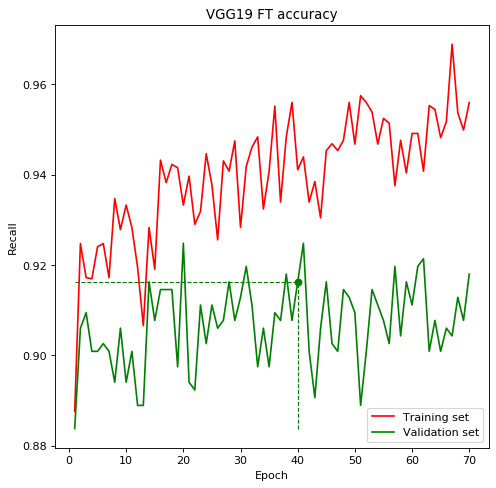

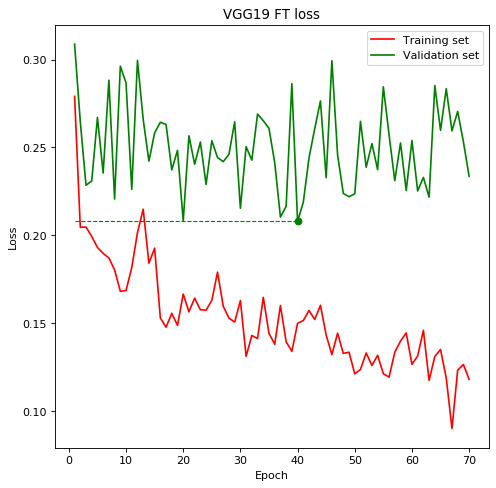

In [18]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();